# THIS FILE CONTAINS FIRST ITERATION OF EXPLORATION OF POTENTIAL VARIABLES AND MODEL 

## W O R K I N P R O G R E S S . . . .

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('../Data/train.csv')
test_data = pd.read_csv('../Data/test.csv')

# 
    - Handle categorial 'parentspecies'

    - However we will see if there is any benefits as we do the feature selection

In [ ]:
def drop_categorical(data):
    # driop the columns with too many missing values
    data = data.drop(columns=['parentspecies'])
    return data
data = drop_categorical(data)
test_data = drop_categorical(test_data)

# Correlation

In [5]:
# Corr absoulte values
correlations = data.corr().abs()['log_pSat_Pa'].sort_values(ascending=False)
print(correlations)

log_pSat_Pa                     1.000000
NumHBondDonors                  0.689196
NumOfConf                       0.513653
hydroperoxide                   0.314053
hydroxyl (alkyl)                0.310452
NumOfAtoms                      0.307337
carboxylic acid                 0.304259
NumOfC                          0.262769
carbonylperoxynitrate           0.223739
MW                              0.199574
NumOfN                          0.183152
ketone                          0.164555
NumOfO                          0.155064
carbonylperoxyacid              0.114080
ester                           0.069376
nitrate                         0.052007
aldehyde                        0.051602
nitroester                      0.051168
ether (alicyclic)               0.045129
NumOfConfUsed                   0.043343
C=C (non-aromatic)              0.042623
peroxide                        0.026531
nitro                           0.016457
C=C-C=O in non-aromatic ring    0.014226
aromatic hydroxy

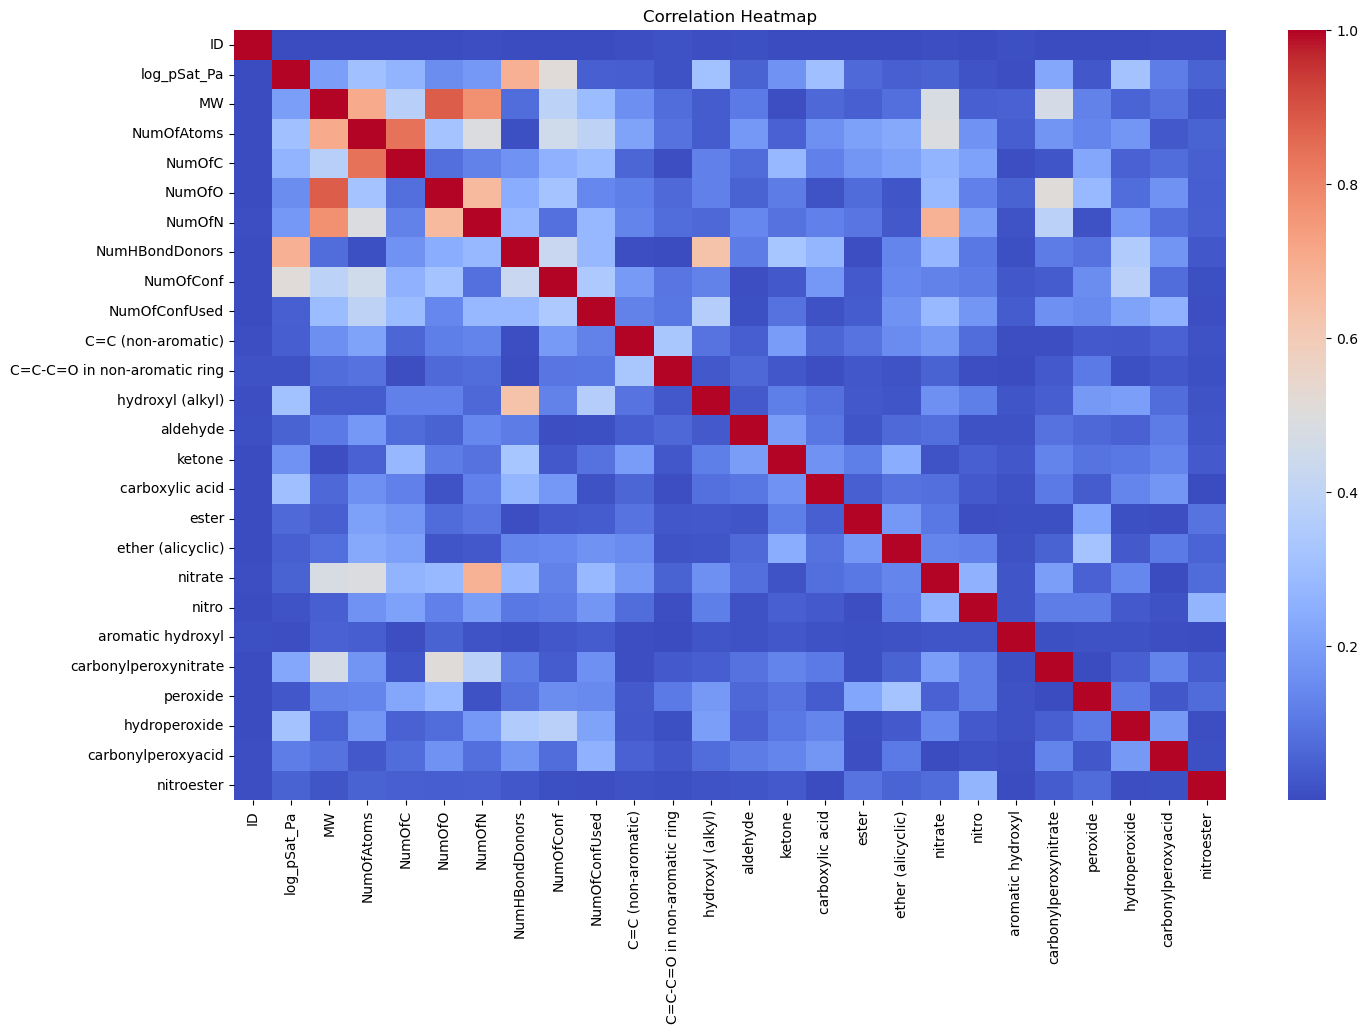

In [6]:
# corr viz
plt.figure(figsize=(16, 10))
sns.heatmap(data.corr().abs(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Why not test this with test data

In [ ]:
# Preprocessing
X = data.drop(columns=['log_pSat_Pa', 'ID'])

y = data['log_pSat_Pa']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

# hyperparameter grid for optimization
param_grid = {
    "num_leaves": [31, 50],
    "learning_rate": [0.2, 0.3], 
    "n_estimators": [50, 200],
    "feature_fraction": [0.8, 0.9], 
    "bagging_fraction": [0.8, 0.9], 
    "bagging_freq": [5, 20],
    "lambda_l1": [0, 0.1, 1], 
    "lambda_l2": [0, 0.1, 1],
}

# LGBM model
lgbm = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective='regression',
                         metric='rmse',
                         random_state=15)

# GridSearchCV ( 3 folds cross-validation)
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best :-) Hyperparameters:", best_params)


y_pred = best_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f"RMSE on test set: {rmse_test}")
print(f'R2 Score on test set: {r2_score(y_test, y_pred)}')

# save the real test data predictions
test_data2 = test_data.copy()
test_data2 = test_data2.drop(columns=['ID'])
y_test_final_pred = best_model.predict(test_data2)
test_data['TARGET'] = y_test_final_pred
write_csv = test_data[['ID', 'TARGET']]
write_csv.to_csv('lgbm_cv_predictions.csv', index=False)

lgb.plot_importance(best_model, max_num_features=10, importance_type='split', figsize=(10,6))
plt.show()

#20min fit


Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 w

AttributeError: 'function' object has no attribute 'drop'

[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


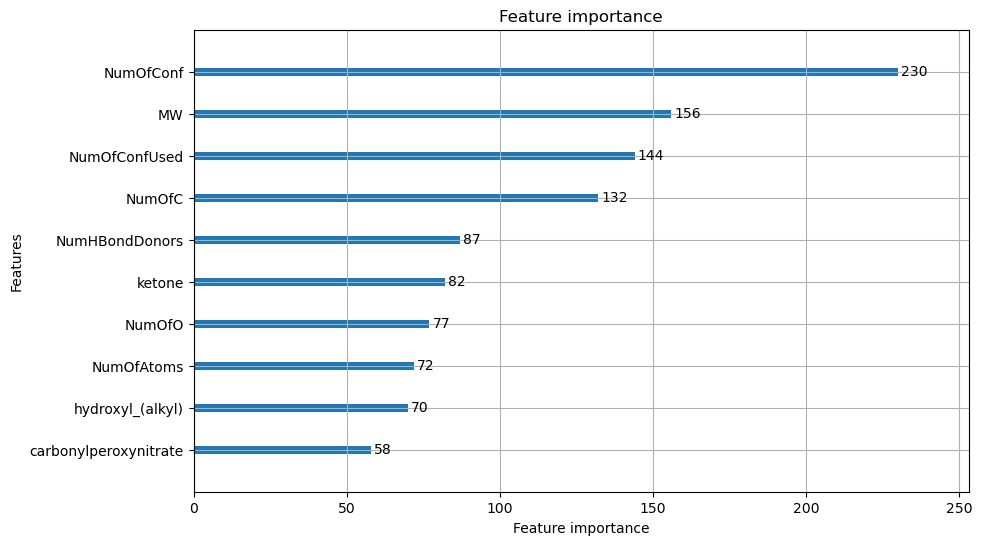

In [10]:
# priint model parameters
print(best_model.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.2, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': None, 'num_leaves': 31, 'objective': 'regression', 'random_state': 15, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'rmse', 'bagging_fraction': 0.9, 'bagging_freq': 20, 'feature_fraction': 0.8, 'lambda_l1': 1, 'lambda_l2': 1}
